In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from OpenGAN.network import Generator
from SimCLR.models.resnet_classifier import ResNetClassifier
from torchvision import transforms
from torch.utils.data import DataLoader
import pickle
import torch.nn.functional as F
import numpy as np
np.random.seed(123)

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
#load generator
generator_path = 'OpenGAN/OpenGAN_runs/epoch-300.GNet'
generator = Generator(nz=256, ngf=64, nc=512)
generator_checkpoint = torch.load(generator_path, map_location=device)
generator.load_state_dict(generator_checkpoint)
generator.to(device)

# Dataset
root_folder = 'SimCLR/datasets'
dataset = CIFAR10(root_folder,transform=None, download=True, train=True)
with open('mu/saved_data/retain_indexes.pt', 'rb') as f:
    retain_indexes = pickle.load(f)
    f.close()
forget_indexes = [i for i in range(len(dataset)) if i not in retain_indexes]
with open('OpenGAN/saved_features/forget_features.pt', 'rb') as f:
    forget_features = torch.load(f)
    f.close()

with open('OpenGAN/saved_features/retain_features.pt', 'rb') as f:
    retain_features = torch.load(f)
    f.close()
forget_features = forget_features.squeeze(-1).squeeze(-1).to(device)
retain_features = retain_features.squeeze(-1).squeeze(-1).to(device)
forget_norm = F.normalize(forget_features, dim=-1)
retain_norm = F.normalize(retain_features, dim=-1)
retain_similarity_matrix = torch.matmul(retain_norm[0:10000], retain_norm[0:10000].T)
retain_similarity_matrix = retain_similarity_matrix - torch.diag_embed(torch.diag(retain_similarity_matrix))
max_indexes = torch.argmax(retain_similarity_matrix, dim=0)
del(retain_similarity_matrix)

Files already downloaded and verified


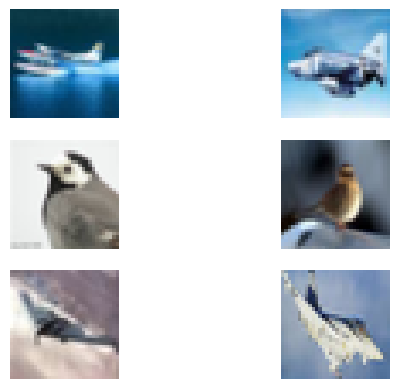

In [9]:
first_img_index = retain_indexes[5]
second_img_index = retain_indexes[max_indexes[5]]
img1 = dataset[first_img_index][0]
img2 = dataset[second_img_index][0]
first_img_index = retain_indexes[2]
second_img_index = retain_indexes[max_indexes[2]]
img3 = dataset[first_img_index][0]
img4 = dataset[second_img_index][0]
first_img_index = retain_indexes[3]
second_img_index = retain_indexes[max_indexes[3]]
img5 = dataset[first_img_index][0]
img6 = dataset[second_img_index][0]
plt.subplot(3, 2, 1)
plt.imshow(img1)
plt.axis("off")
plt.subplot(3, 2, 2)
plt.imshow(img2)
plt.axis("off")
plt.subplot(3, 2, 3)
plt.imshow(img3)
plt.axis("off")
plt.subplot(3, 2, 4)
plt.imshow(img4)
plt.axis("off")
plt.subplot(3, 2, 5)
plt.imshow(img5)
plt.axis("off")
plt.subplot(3, 2, 6)
plt.imshow(img6)
plt.axis("off")
plt.savefig("cosin_similarity.pdf")

In [5]:
forget_similarity_matrix = torch.matmul(forget_norm, forget_norm.T)

forget_similarity_matrix = forget_similarity_matrix - torch.diag_embed(torch.diag(forget_similarity_matrix))
max_indexes = torch.argmax(forget_similarity_matrix, dim=0)
del(forget_similarity_matrix)

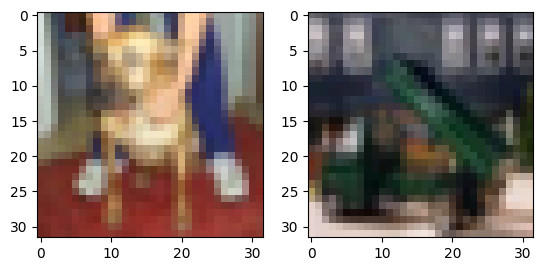

In [6]:
first_img_index = forget_indexes[5]
second_img_index = forget_indexes[max_indexes[5]]
img1 = dataset[first_img_index][0]
img2 = dataset[second_img_index][0]
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.show()

In [7]:
selected_fake_features_forget = []
selected_fake_features_retain = []
with torch.no_grad():
    for i in range(forget_features.shape[0]):
        noise = torch.randn(100, 256, 1, 1).to(device)
        fake = generator(noise)
        similarity_vec = torch.matmul(F.normalize(forget_features[i].unsqueeze(0)), F.normalize(fake).T)
        print(similarity_vec)
        fake_feature = fake[torch.argmax(similarity_vec)]
        selected_fake_features_forget.append(fake_feature)
    for i in range(forget_features.shape[0]):
        noise = torch.randn(100, 256, 1, 1).to(device)
        fake = generator(noise)
        similarity_vec = torch.matmul(F.normalize(retain_features[i].unsqueeze(0)), F.normalize(fake).T)
        fake_feature = fake[torch.argmax(similarity_vec)]
        selected_fake_features_retain.append(fake_feature)
fake_forget_features = torch.stack(selected_fake_features_forget, dim=0).squeeze(-1).squeeze(-1)
fake_retain_features = torch.stack(selected_fake_features_retain, dim=0).squeeze(-1).squeeze(-1)
fake_forget_norm = F.normalize(fake_forget_features, dim=1)
fake_retain_norm = F.normalize(fake_retain_features, dim=1)
fake_forget_sim = torch.matmul(fake_forget_norm, forget_norm.T)
fake_retain_sim = torch.matmul(fake_retain_norm, retain_norm[0:forget_features.shape[0]].T)
print(torch.mean(fake_forget_sim))
print(torch.mean(fake_retain_sim))

C:\Users\kangl\AppData\Local\Temp\ipykernel_14524\3198474899.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3641.)
  similarity_vec = torch.matmul(F.normalize(forget_features[i].unsqueeze(0)), F.normalize(fake).T)


tensor([[[[-0.0648,  0.0201,  0.0385,  0.0087,  0.0393, -0.1092,  0.0369,
            0.0180,  0.0143,  0.0915,  0.0188,  0.0365,  0.0250,  0.0335,
           -0.1047,  0.2205,  0.0343,  0.0330,  0.0335,  0.0221, -0.1083,
            0.0186,  0.0363,  0.0022, -0.0277,  0.1871,  0.0376,  0.2369,
            0.1330,  0.0970,  0.0176,  0.0202, -0.0365,  0.0191,  0.0307,
            0.0395,  0.0179,  0.0193,  0.0370,  0.0187, -0.0571,  0.0380,
            0.0191,  0.0181,  0.0286,  0.0171,  0.0388,  0.0136,  0.0388,
            0.0382,  0.0193,  0.0193,  0.2240,  0.0191,  0.0646,  0.0385,
            0.0764,  0.0366,  0.0389,  0.0370, -0.0121,  0.0382,  0.0185,
            0.0370,  0.0379,  0.0180, -0.1597,  0.0306,  0.0388,  0.0391,
            0.0386,  0.0180,  0.2258,  0.0185,  0.0380,  0.0193,  0.0337,
            0.1242, -0.0665,  0.0389,  0.0186,  0.0211,  0.0190, -0.0305,
            0.0148, -0.0549,  0.0383,  0.0239,  0.0193,  0.0211,  0.0185,
            0.0395,  0.0325,  0.0302, 